In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. **Download the dataset** from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods `predict()`, `cost()`, `gradient_cost()`, `accuracy()`. As a test, just invoke the method by suitable dummy values.
3. Implement (full) **batch GD** for minimizing the CE cost **(without autograd)**. Plot cost vs the number of epochs.
4. Implement (full) **batch GD** for minimizing the CE cost, this time with **autograd**. show that you obtain consistent results.
5. **Tune the learning rate**. What is a reasonable learning rate?

### 1. Load Data

In [35]:
import pandas as pd
df = pd.read_csv("Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


#### Normalization and Turning into Torch Tensors

In [36]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64)) # input variables

# standardize input scalars
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)

# replace strings in response variables with 0s and 1s
Y = torch.tensor(('Abnormal'==df.values[:,-1])).double().reshape(-1,1) 
#NOTE: '-1' in reshape means, as many as it takes to satisfy other dimension

print("X shape: ", X.shape, "\nY shape:", Y.shape)

X shape:  torch.Size([310, 12]) 
Y shape: torch.Size([310, 1])


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W^\intercal = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost (maxL):  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [37]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)

In [47]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    """ Argument
            X: (NxD)-vector, list of input vectors, 1st column 1s -> bias
            W: (1xD)-vector, weights for each feature, w0 -> bias
        Return
            s: (Nx1)-vector, softmax-squeezed probability predictions for each input vector
    """
    # YOUR CODE (START)
    # linear function
    z = X@W.T

    # softmax function NOTE: no parameters, centered in interval [-3,3] for standardized x-values
    s = np.exp(z)/(1+np.exp(z))
    return s
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    # make predictions
    Y_hat = predict(X,W) # (Nx1) col-vector

    # Cost function
    C = -(1/N)*( Y.T@np.log(Y_hat) + (1-Y).T@np.log(1-Y_hat)) # Summing achieved w/ inner products
    return C.squeeze().item()
    # YOUR CODE (END)

W = torch.randn((1,13), dtype=torch.double)
print(cost(X,Y,W))
print("test prediction: ", predict(X[0],W))

1.3811165565894894
test prediction:  tensor([0.0375], dtype=torch.float64)


In [39]:
def gradient_cost(X,Y,W):
    """ gradient of cost function for set of weights W """
    # YOUR CODE (START)
    s = predict(X, W) # (Nx1)
    gradC = (1/N)*((s-Y).T@X).T
    
    return gradC
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    prediction = Yhat
    prediction[prediction<0.5] = 0
    prediction[prediction>=0.5] = 1

    # accuracy = correct predictions / total predictions
    n = prediction.shape[0]
    nCorrect = sum(prediction == Y).item() # sum() function treats True & False as 1 & 0
    accuracy = nCorrect / n

    return accuracy
    # YOUR CODE (END)

print(accuracy(Y,predict(X,W)))

0.4645161290322581


Just for testing:

In [40]:
W = torch.randn((1,13), dtype=torch.double) # initialize random weight vector
print("test prediction: ", predict(X[0],W))
print("cost for random weights: ", cost(X,Y,W))
print("gradient of cost for random weights", gradient_cost(X,Y,W))
print("prediction accuracy for random weights", accuracy(Y, predict(X,W)))

test prediction:  tensor([0.9959], dtype=torch.float64)
cost for random weights:  1.8019799875545885
gradient of cost for random weights tensor([[-0.3089],
        [-0.2955],
        [-0.1907],
        [-0.3447],
        [-0.2373],
        [ 0.1265],
        [-0.3478],
        [ 0.0167],
        [ 0.0435],
        [ 0.0507],
        [ 0.1081],
        [-0.1099],
        [ 0.1060]], dtype=torch.float64)
prediction accuracy for random weights 0.34838709677419355


### 3. Implement Full Batch Gradient Descent

C:\Users\ayome\AppData\Local\Temp\ipykernel_8764\252379086.py:24: RuntimeWarning: divide by zero encountered in log
  C = -(1/N)*( Y.T@np.log(Y_hat) + (1-Y).T@np.log(1-Y_hat)) # Summing achieved w/ inner products


Training Accuracy (max,end): 0.835484, 0.829032
Training Cost (end): nan


Text(0.5, 1.0, 'accuracies')

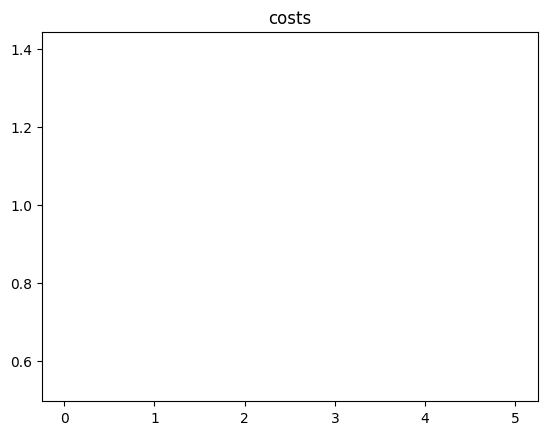

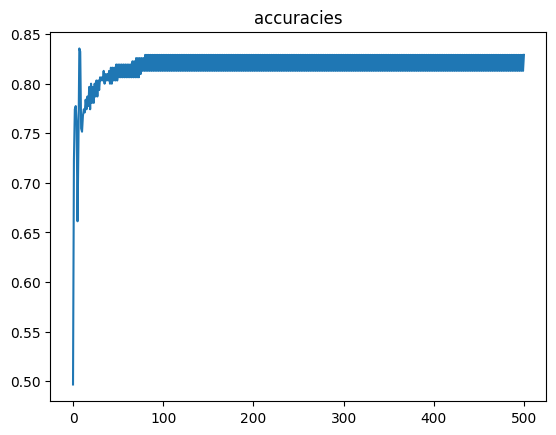

In [61]:
# adjust if needed
nepochs = 500
lr = 15

## initial weight parameters
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    W = W - lr * gradient_cost(X, Y, W).T
    costs.append(cost(X,Y,W))
    accs.append(accuracy(Y,predict(X,W)))

# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1])
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.title("costs")
plt.figure(2)
plt.plot(range(nepochs+1),accs)
plt.title("accuracies")

### 4. Implement Full Batch Gradient Descent with PyTorch's autograd

In [46]:
nepochs = 1000
lr = 1

## initial weight parameters
W = torch.randn((1,13), dtype=torch.double, requires_grad = True)

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W] , lr = lr)

# track the costs
costs = []


# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    pred = predict(X,W)
    loss = cost_ce(pred, Y)
    costs.append(loss.detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


costs.append(cost_ce(predict(X,W), Y).detach().numpy())
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

**most efficient:** lr=5 has very fast dropoff in cost with pronounced "elbow"

**yet works:** at lr=10 accuracy is taking longer to converge again. 

**not working anymore:** at lr=20, oscillations don't stop